# **Word Embedding**

**Word embedding is a dense representation of words in the form of numeric vectors. It can be learned using a variety of language models. The word embedding representation is able to reveal many hidden relationships between words. For example, vector(“cat”) - vector(“kitten”) is similar to vector(“dog”) - vector(“puppy”). This post introduces several models for learning word embedding and how their loss functions are designed for the purpose.**

# Skip Gram Implementation

In [13]:
import re
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Defines a Vocabulary class to map words to unique indices and vice versa. The vocabulary is built from a corpus of sentences, counting word occurrences, and filtering based on a minimum frequency threshold. This helps create a lookup for words and their corresponding indices.

In [2]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.word_count = defaultdict(int)
        self.total_words = 0
        self.vocab_size = 0

    def build_vocab(self, sentences, min_count=2):
        # Count words
        for word in sentences:
            self.word_count[word] += 1

        # Create word2idx and idx2word mapping
        idx = 0
        for word, count in self.word_count.items():
            if count >= min_count:
              self.word2idx.update({word: idx})
              idx += 1

        # self.word2idx = {word: idx for idx, (word, count) in enumerate(self.word_count.items()) if count >= min_count}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
        self.total_words = sum([count for word, count in self.word_count.items() if count >= min_count])

    def word_to_index(self, word):
        return self.word2idx.get(word, -1)

    def index_to_word(self, index):
        return self.idx2word.get(index, None)


A function to generate training data for a model using the skip-gram approach. It builds pairs of words (center word and context words) from a list of sentences based on a specified window size.

In [3]:
def generate_training_data(vocab, sentences, window_size=2):
    training_data = []
    sentence_indices = [vocab.word_to_index(word) for word in sentences if vocab.word_to_index(word) != -1]

    for center_idx, center_word in enumerate(sentence_indices):
        context_start = max(0, center_idx - window_size)
        context_end = min(len(sentence_indices), center_idx + window_size + 1)

        for context_idx in range(context_start, context_end):
            if context_idx != center_idx:
                context_word = sentence_indices[context_idx]
                training_data.append((center_word, context_word))

    return np.array(training_data)


A skip-gram model predicts the context (or neighbors) of a word, given the word itself. The model is trained on skip-grams, which are n-grams that allow tokens to be skipped (see the diagram below for an example). The context of a word can be represented through a set of skip-gram pairs of `(target_word, context_word)` where `context_word` appears in the neighboring context of `target_word`.

Consider the following sentence of eight words:

> The wide road shimmered in the hot sun.

The context words for each of the 8 words of this sentence are defined by a window size. The window size determines the span of words on either side of a `target_word` that can be considered a `context word`. Below is a table of skip-grams for target words based on different window sizes.

![word2vec_skipgrams](https://tensorflow.org/text/tutorials/images/word2vec_skipgram.png)

The training objective of the skip-gram model is to maximize the probability of predicting context words given the target word. For a sequence of words *w<sub>1</sub>, w<sub>2</sub>, ... w<sub>T</sub>*, the objective can be written as the average log probability

![word2vec_skipgram_objective](https://tensorflow.org/text/tutorials/images/word2vec_skipgram_objective.png)

where `c` is the size of the training context. The basic skip-gram formulation defines this probability using the softmax function.

![word2vec_full_softmax](https://tensorflow.org/text/tutorials/images/word2vec_full_softmax.png)

where *v* and *v<sup>'<sup>* are target and context vector representations of words and *W* is vocabulary size.

In [4]:
class Word2Vec:
    def __init__(self, vocab_size, embed_size=100, learning_rate=0.001):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.learning_rate = learning_rate

        # Initialize weight matrices
        self.W = np.random.uniform(-0.5, 0.5, (vocab_size, embed_size))  # Input to hidden
        self.W_prime = np.random.uniform(-0.5, 0.5, (embed_size, vocab_size))  # Hidden to output

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def train(self, training_data, epochs=1000):
        for epoch in range(epochs):
            loss = 0
            for center_word, context_word in training_data:
                h = self.W[center_word]  # Get hidden layer (input->hidden)
                u = np.dot(h, self.W_prime)  # Predict output
                y_pred = self.softmax(u)

                # One-hot encoding the true context word
                y_true = np.zeros(self.vocab_size)
                y_true[context_word] = 1

                # Calculate the error
                error = y_pred - y_true

                # Update weights with gradient descent
                self.W_prime -= self.learning_rate * np.outer(h, error)
                self.W[center_word] -= self.learning_rate * np.dot(self.W_prime, error)

                # Calculate loss (cross-entropy)
                loss -= np.log(y_pred[context_word])

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')



Read a Persian stopwords file, tokenizes a Persian text sample, removes stopwords, and reconstructs the filtered sentence. This preprocessing is essential for cleaning text data before further processing, such as embedding or modeling.

In [ ]:
# Reading the Persian stopwords from the file
with open('persian.txt', 'r', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())  # Using a set for faster lookup

# Sample Persian text
text = "ملکه و زن ها در کنار همسران و خانواده خود یعنی شاه و مرد ها در یک سرزمین پهناور زندگی می‌کردند شاه همیشه به مرد ها تذکر میداد که قدرت در اتحاد مرد ها و شاه نهفته است و در این قلمرو ملکه به زن ها یادآوری می‌کرد که همبستگی زن ها و ملکه مهم است و در این داستان هر مرد که نزد شاه یا زن که نزد ملکه می‌آمد از آنها حکم می‌گرفت تا به دیگران کمک کنند شاه عادل و قادر بود و ملکه خردمند و زیبا و هر مرد که از حکمت شاه یا زن که از عدالت ملکه راضی نبود نزد آنها می‌رفت تا شکایت خود را مطرح کند شاه و مرد و ملکه و زن در کنار هم بودند و هیچ کس از شاه یا ملکه نمی‌ترسید شاه همیشه به زبان میاورد که مرد ها باید به یکدیگر کمک کنند و ملکه تأکید داشتند زن ها هم باید متحد باشند"

# Tokenizing the text (you can modify the tokenizer if needed)
words = text.split()

# Removing stopwords
filtered_text = [word for word in words if word not in stopwords]

# Joining the words back into a sentence
cleaned_text = ' '.join(filtered_text)

print(cleaned_text)


ملکه زن همسران خانواده شاه مرد سرزمین پهناور زندگی می‌کردند شاه مرد تذکر میداد قدرت اتحاد مرد شاه نهفته قلمرو ملکه زن یادآوری می‌کرد همبستگی زن ملکه مهم داستان مرد شاه زن ملکه می‌آمد حکم می‌گرفت کمک شاه عادل قادر ملکه خردمند زیبا مرد حکمت شاه زن عدالت ملکه راضی می‌رفت شکایت مطرح شاه مرد ملکه زن شاه ملکه نمی‌ترسید شاه زبان میاورد مرد کمک ملکه تأکید زن متحد


In [ ]:
# wiki_dump_path = 'enwiki-latest-pages-articles.xml.bz2'  # Path to your Wikipedia dump file

# # Load and preprocess the dataset
# sentences = list(load_wiki_data(wiki_dump_path))

# Build the vocabulary
vocab = Vocabulary()
vocab.build_vocab(cleaned_text.split(' '))

# Generate training data
training_data = generate_training_data(vocab, cleaned_text.split(' '))

# Initialize and train Word2Vec model
word2vec_model = Word2Vec(vocab.vocab_size)
word2vec_model.train(training_data, epochs=1000)


Epoch 0, Loss: 217.34630970038413
Epoch 100, Loss: 181.5196690584462
Epoch 200, Loss: 181.10669945586082
Epoch 300, Loss: 180.9694558003934
Epoch 400, Loss: 180.89839648378222
Epoch 500, Loss: 180.85521332091994
Epoch 600, Loss: 180.82638982519742
Epoch 700, Loss: 180.80589790542393
Epoch 800, Loss: 180.7906516880482
Epoch 900, Loss: 180.77891218264517


Defines a function to retrieve the word embedding for a given word from a Word2Vec model. If the word exists in the vocabulary, its corresponding vector is returned; otherwise, None is returned.

In [ ]:
def get_word_embedding(word, vocab, model):
    word_idx = vocab.word_to_index(word)
    if word_idx != -1:
        return model.W[word_idx]
    else:
        return None

embedding = get_word_embedding("مرد", vocab, word2vec_model)
print(embedding)


[ 0.28634888 -0.13093086 -0.0201545   0.05271528 -0.09334632  0.15840051
 -0.34445462  0.42237267 -0.38221831 -0.19108261  0.47323099  0.4272571
  0.13851498 -0.22135522  0.23678668 -0.28319392  0.30872885  0.39926364
 -0.52409306 -0.22185257 -0.3983401  -0.16248012  0.2544923  -0.30862513
 -0.14724238  0.15341193  0.22308444 -0.03885356  0.50674215  0.3120602
 -0.22368227 -0.42046334  0.34820725 -0.11986774 -0.39504836 -0.23070816
 -0.40190402  0.41267271 -0.07634545 -0.19427366  0.22134564 -0.38971622
 -0.54359274  0.44488732  0.1493101  -0.42904048  0.24654613 -0.26918437
  0.02520455 -0.3487133   0.34302321 -0.32930649 -0.26991703  0.21795934
 -0.30534359 -0.08726335  0.40263831  0.10635999 -0.3494115  -0.16635264
  0.40776723 -0.01813031  0.21182939 -0.40908686  0.2195951   0.39119267
 -0.2490812   0.3413859   0.20336299 -0.11541427  0.00648979 -0.27482335
 -0.37028258  0.2318869   0.46906915 -0.27019587 -0.18769502 -0.00147952
 -0.31550756  0.12446    -0.17474903 -0.36052425  0.0

Cosine similarity is used to find words similar to a target word. The cosine similarity between two vectors
𝑢
⃗
u
  and
𝑣
⃗
v
  is:

cosine_similarity
(
𝑢
,
𝑣
)
=
𝑢
⋅
𝑣
∥
𝑢
∥
∥
𝑣
∥
cosine_similarity(u,v)=
∥u∥∥v∥
u⋅v
​

It ranges from -1 (opposite) to 1 (identical).

In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def find_similar_words(word, vocab, model, k=5):
    word_idx = vocab.word_to_index(word)

    if word_idx == -1:
        return f"Word '{word}' not in vocabulary."

    word_vector = model.W[word_idx]
    similarities = []

    for idx in range(vocab.vocab_size):
        if idx != word_idx:  # Skip the word itself
            other_word_vector = model.W[idx]
            sim_score = cosine_similarity(word_vector, other_word_vector)
            similarities.append((vocab.index_to_word(idx), sim_score))

    # Sort by similarity scores in descending order
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    return similarities[:k]

# Example usage:
similar_words = find_similar_words("ملکه", vocab, word2vec_model, k=5)
print(similar_words)


[('مرد', -0.04647404927591914), ('شاه', -0.1729206822382368), ('کمک', -0.17484015224775992), ('زن', -0.18247386544478783)]


Perform a word analogy task (e.g., "man is to king as woman is to X") by computing vector differences and finding the word most similar to the resulting vector. The function identifies the word closest to the vector result of the analogy operation.

In [ ]:
def find_analogy(word_a, word_b, word_c, vocab, model):
    # Convert words to their vector representations
    vec_a = model.W[vocab.word_to_index(word_a)] if vocab.word_to_index(word_a) != -1 else None
    vec_b = model.W[vocab.word_to_index(word_b)] if vocab.word_to_index(word_b) != -1 else None
    vec_c = model.W[vocab.word_to_index(word_c)] if vocab.word_to_index(word_c) != -1 else None

    if vec_a is None or vec_b is None or vec_c is None:
        return f"One of the words '{word_a}', '{word_b}', or '{word_c}' is not in the vocabulary."

    # Word analogy: vector equation (vec_d = vec_a - vec_b + vec_c)
    target_vec = vec_a - vec_b + vec_c
    similarities = []

    # Find the word most similar to the resulting vector
    for idx in range(vocab.vocab_size):
        other_word_vector = model.W[idx]
        sim_score = cosine_similarity(target_vec, other_word_vector)
        similarities.append((vocab.index_to_word(idx), sim_score))

    # Sort by similarity and return the most similar word (excluding word_a, word_b, word_c)
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Filter out the original words from the analogy (optional)
    filtered_similarities = [word for word in similarities if word[0] not in {word_a, word_b, word_c}]

    return filtered_similarities[0] if filtered_similarities else None

# Example usage:
analogy_result = find_analogy("مرد", "شاه", "زن", vocab, word2vec_model)
print(analogy_result)


('ملکه', -0.0318624516463186)


# Using a Pre-Trained Model

**The quality of word embeddings improves as the model is trained on larger and more diverse datasets. Word2Vec models, for example, learn better representations of words when exposed to more data because they capture a richer context of how words are used in different situations. To ensure high-quality embeddings for our tasks, we will use a pre-trained Word2Vec model that has been trained on a vast corpus of news articles. This large dataset allows the model to learn nuanced relationships between words, resulting in more accurate and meaningful embeddings.**

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text, minimum_length=1, stopword_removal=True, stopwords_domain=[], lower_case=True,
                       punctuation_removal=True):
    """
    preprocess text by removing stopwords, punctuations, and converting to lowercase, and also filter based on a min length
    for stopwords use nltk.corpus.stopwords.words('english')
    for punctuations use string.punctuation

    Parameters
    ----------
    text: str
        text to be preprocessed
    minimum_length: int
        minimum length of the token
    stopword_removal: bool
        whether to remove stopwords
    stopwords_domain: list
        list of stopwords to be removed base on domain
    lower_case: bool
        whether to convert to lowercase
    punctuation_removal: bool
        whether to remove punctuations
    """
    if lower_case:
        text = text.lower()

    if punctuation_removal:
        text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    if stopword_removal:
        stop_words = set(stopwords.words('english'))
        if stopwords_domain:
            stop_words.update(stopwords_domain)
        tokens = [word for word in tokens if word not in stop_words]

    tokens = [word for word in tokens if len(word) >= minimum_length]

    processed_text = ' '.join(tokens)

    return processed_text

Implementation of a class that uses a pre-trained Word2Vec model to compute word embeddings and perform word analogy tasks. It preprocesses the input text, generates embeddings for each word in a query, and averages them to create a sentence embedding.

In [10]:
class PreTrainedWord2Vec:
    """
    A class used fro a pre-trained Word2Vec model and generate embeddings for text data.

    Attributes
    ----------
    model: Word2Vec model
        The trained Word2Vec model.
    """

    def __init__(self, preprocessor=None, model=None):
        """
        Initializes the FastText with a preprocessor and a model.

        Parameters
        ----------
        model : Word2Vec model
        """
        self.preprocessor = preprocessor
        self.model = model



    def get_query_embedding(self, query):
        """
        Generates an embedding for the given query.

        Parameters
        ----------
        query : str
            The query to generate an embedding for.


        Returns
        -------
        np.ndarray
            The embedding for the query.
        """
        if self.preprocessor:
            query = self.preprocessor(query)

        word_vectors = []

        for word in query.split(' '):
            if word in model:
                word_vectors.append(model[word])


        sentence_vector = np.mean(word_vectors, axis=0)
        return sentence_vector


    def analogy(self, word1, word2, word3):
        """
        Perform an analogy task: word1 is to word2 as word3 is to __.

        Args:
            word1 (str): The first word in the analogy.
            word2 (str): The second word in the analogy.
            word3 (str): The third word in the analogy.

        Returns:
            str: The word that completes the analogy.
        """
        new_word1 = self.preprocessor(word1)
        new_word2 = self.preprocessor(word2)
        new_word3 = self.preprocessor(word3)
        word1_emb = self.model[new_word1]
        word2_emb = self.model[new_word2]
        word3_emb = self.model[new_word3]

        result = word3_emb + (word2_emb - word1_emb)

        vocab_vectors = {word: self.model[word] for word in list(self.model.index_to_key)}

        input_words = {word1, word2, word3}
        possible_results = {word: vec for word, vec in vocab_vectors.items() if word not in input_words}

        nearest_word = max(possible_results, key=lambda word: np.dot(possible_results[word], result) / (
                    np.linalg.norm(possible_results[word]) * np.linalg.norm(result)))

        return nearest_word

    def plot_words(self, words):
        """
        Plots the given words in a 2D space using PCA for dimensionality reduction.

        Parameters
        ----------
        words : list of str
            A list of words to be plotted.
        """
        # Collect the word vectors for the specified words
        word_vectors = [self.model[word] for word in words if word in self.model]

        # Apply PCA to reduce the dimensions to 2D
        pca = PCA(n_components=2)
        word_vecs_2d = pca.fit_transform(word_vectors)

        # Plotting the words
        plt.figure(figsize=(10, 7))
        for i, word in enumerate(words):
            if word in self.model:
                plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
                plt.text(word_vecs_2d[i, 0] + 0.01, word_vecs_2d[i, 1] + 0.01, word, fontsize=12)

        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.title("Word Embeddings in 2D space")
        plt.grid(True)
        plt.show()

In [8]:
!pip install gensim

Loading a pre-trained Word2Vec model (Google News corpus) using Gensim's downloader. This model is used in subsequent cells for word embedding tasks.

In [9]:
import gensim.downloader as api

# Load a pre-trained skip-gram Word2Vec model (Google News model)
model = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [11]:
w2v = PreTrainedWord2Vec(preprocess_text, model)

In [12]:
print(10 * "*" + "Similarity" + 10 * "*")
word = 'queen'
neighbors = w2v.model.most_similar(word)

for neighbor in neighbors:
    print(f"Word: {neighbor[1]}, Similarity: {neighbor[0]}")

print(10 * "*" + "Analogy" + 10 * "*")
word1 = "man"
word2 = "woman"
word3 = "boy"
print(f"Similarity between {word1} and {word2} is like similarity between {word3} and {w2v.analogy(word1, word2, word3)}")


**********Similarity**********
Word: 0.739944338798523, Similarity: queens
Word: 0.7070532441139221, Similarity: princess
Word: 0.6510956883430481, Similarity: king
Word: 0.6383602023124695, Similarity: monarch
Word: 0.6357026696205139, Similarity: very_pampered_McElhatton
Word: 0.6163407564163208, Similarity: Queen
Word: 0.6060680150985718, Similarity: NYC_anglophiles_aflutter
Word: 0.5923796892166138, Similarity: Queen_Consort
Word: 0.5908074975013733, Similarity: princesses
Word: 0.5637185573577881, Similarity: royal
**********Analogy**********
Similarity between man and woman is like similarity between boy and girl


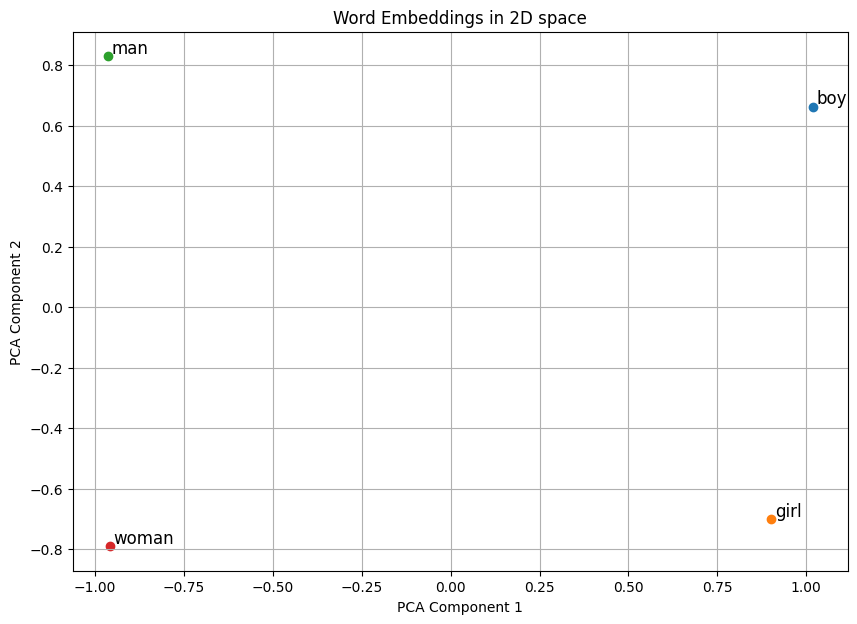

In [16]:
w2v.plot_words(['boy', 'girl', 'man', 'woman'])

# Sentiment Prediction

**We will use the embedding model as input for a simple neural network to predict whether the tone of a sentence is positive or negative. By feeding the sentence embeddings into the network, the model can learn patterns that distinguish between positive and negative sentiments, enabling it to classify sentences based on their tone.**

Defining the full pipeline for sentiment analysis:

1. Prepares positive and negative sentiment examples.
2. Splits the data into training and validation sets.
3. Defines a custom dataset class to retrieve embeddings for each sentence.
4. Creates a neural network model for sentiment classification.
5. Trains the model using a binary classification approach, optimizing over several epochs and computing validation accuracy.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import fasttext
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 1. DATASET: Positive and Negative Examples
positive_examples = [
    "I absolutely loved the movie!",
    "The food was delicious and the service was excellent.",
    "This product exceeded my expectations.",
    "I had a fantastic time at the concert.",
    "The weather was beautiful during our vacation.",
    "The customer support team was incredibly helpful.",
    "I would definitely recommend this restaurant.",
    "The book was a joy to read from start to finish.",
    "I'm very happy with my purchase.",
    "The experience was truly unforgettable."
]

negative_examples = [
    "The movie was terrible and a complete waste of time.",
    "The food was cold and the service was slow.",
    "I was very disappointed with the quality of this product.",
    "The concert was boring and not worth the money.",
    "The weather ruined our entire trip.",
    "The customer support team was unhelpful and rude.",
    "I will never visit this restaurant again.",
    "The book was poorly written and hard to follow.",
    "I'm extremely dissatisfied with my purchase.",
    "The experience was awful and I regret it."
]

positive_labels = [1] * len(positive_examples)
negative_labels = [0] * len(negative_examples)

sentences = positive_examples + negative_examples
labels = positive_labels + negative_labels

# 2. Shuffle and Split into Training and Validation Sets
dataset = list(zip(sentences, labels))
random.shuffle(dataset)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)


# 4. Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, data, word2vec_model):
        self.data = data
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, label = self.data[idx]
        embedding = self.get_embedding(sentence)
        return embedding, torch.tensor(label, dtype=torch.float)

    def get_embedding(self, sentence):
        """Get word2vec embedding for a given sentence"""
        embedding = self.word2vec_model.get_query_embedding(sentence)
        return torch.tensor(embedding).float()

# 5. Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# 6. Hyperparameters and Dataset Preparation
embedding_dim = 300  # Word2Vec embedding size
train_dataset = SentimentDataset(train_data, w2v)
val_dataset = SentimentDataset(val_data, w2v)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# 7. Training Setup
nn_model = SentimentClassifier(embedding_dim)
criterion = nn.BCELoss()  # Binary cross entropy loss for binary classification
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# 8. Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0
    for embeddings, labels in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(embeddings)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    nn_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            outputs = nn_model(embeddings)
            predicted = (outputs.squeeze() >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training complete.")


Epoch [1/50], Loss: 2.7833, Validation Accuracy: 25.00%
Epoch [2/50], Loss: 2.7280, Validation Accuracy: 25.00%
Epoch [3/50], Loss: 2.6813, Validation Accuracy: 25.00%
Epoch [4/50], Loss: 2.6435, Validation Accuracy: 25.00%
Epoch [5/50], Loss: 2.6010, Validation Accuracy: 25.00%
Epoch [6/50], Loss: 2.5569, Validation Accuracy: 25.00%
Epoch [7/50], Loss: 2.5034, Validation Accuracy: 50.00%
Epoch [8/50], Loss: 2.4429, Validation Accuracy: 50.00%
Epoch [9/50], Loss: 2.3846, Validation Accuracy: 50.00%
Epoch [10/50], Loss: 2.3233, Validation Accuracy: 50.00%
Epoch [11/50], Loss: 2.2485, Validation Accuracy: 50.00%
Epoch [12/50], Loss: 2.1734, Validation Accuracy: 50.00%
Epoch [13/50], Loss: 2.0925, Validation Accuracy: 50.00%
Epoch [14/50], Loss: 2.0019, Validation Accuracy: 50.00%
Epoch [15/50], Loss: 1.9148, Validation Accuracy: 50.00%
Epoch [16/50], Loss: 1.8199, Validation Accuracy: 50.00%
Epoch [17/50], Loss: 1.7248, Validation Accuracy: 50.00%
Epoch [18/50], Loss: 1.6325, Validation 

Implementation of a function to predict the sentiment of a given sentence using the trained sentiment analysis model. It embeds the sentence using the Word2Vec model, passes it through the neural network, and outputs a prediction of either "positive" or "negative."

In [ ]:
def predict_sentiment(nn_model, sentence, w2v):
    """
    Predicts the sentiment of a given sentence using the trained model.

    Parameters
    ----------
    nn_model : SentimentClassifier
        The trained sentiment classification model.
    sentence : str
        The input sentence to classify.
    w2v : Word2Vec model
        The model used to generate embeddings.

    Returns
    -------
    str
        The predicted sentiment ('positive' or 'negative').
    """
    # Step 1: Get FastText embedding for the sentence
    embedding = w2v.get_query_embedding(sentence)
    embedding = torch.tensor(embedding).float().unsqueeze(0)  # Add batch dimension

    # Step 2: Pass the embedding through the model to get prediction
    nn_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = nn_model(embedding)

    # Step 3: Interpret the result
    prediction = output.item()  # Get the output as a scalar value
    sentiment = "positive" if prediction >= 0.5 else "negative"

    return sentiment




In [ ]:
# Example usage
query_sentence = "The movie was terrible and a i hated it"
predicted_sentiment = predict_sentiment(nn_model, query_sentence, w2v)
print(f"Sentiment of the query '{query_sentence}': {predicted_sentiment}")

Sentiment of the query 'The movie was terrible and a i hated it': negative


In [ ]:
# Example usage
query_sentence = "The movie was amazing and i loved it"
predicted_sentiment = predict_sentiment(nn_model, query_sentence, w2v)
print(f"Sentiment of the query '{query_sentence}': {predicted_sentiment}")

Sentiment of the query 'The movie was amazing and i loved it': positive
